<H1> RF </H1> <br> 
 scikit-rf  Voltage and current in a transmission line<br> 
<hr> 
<H2>Modification history </H2>
<table>
    <tr>
        <th> Modified </th>
        <th> BY </th>
        <th> Reason </th>
    </tr>
    <tr>
        <td> 30-Jun-24</td>
        <td> CBL </td>
        <td> Original </td>
    </tr>
</table>

<hr> 
<H2> References </H2> 
<a href = "https://scikit-rf.readthedocs.io/en/latest/examples/circuit/Voltages%20and%20Currents%20in%20Circuits.html"> Example circuits </a>
<br> 
<img src="https://scikit-rf.readthedocs.io/en/latest/_images/transmission_line_properties_vi.svg"> 

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import math
import skrf as rf
from pylab import *
# skrf figure styling
rf.stylely()

In [202]:
freq = rf.Frequency(250, npoints=1, unit='MHz')
# define the transmission line and load
Z_0 = 75   # line impedence.
Z_L = 150  # load impedence
d   = 12   # line length in meters d (above)
VF  = 0.67 # velocity factor
att = 0.02 # Np/m equivalent to 0.1737 dB/m

In order to get the RF parameters of the transmission line, it is necessary to derive the propagation constant of the line. The propagation constant $\gamma $ of the line is defined in scikit-rf as $\gamma = \alpha + j*\beta$ where $\alpha$ is the attenuation in (Neper/m) and $\beta = {2*\pi\over{\lambda}} = {{\omega\over{\c}}\over{VF}} = {\omega\over{c}\sqrt{\epsilon_r}}$ the phase constant. <br> 

First the wavelength in the coaxial cable is: <br> 
$\lambda = {c\over{f\sqrt{\epsilon_r}}} = {c\over{f}}VF$

In [203]:
lambd = rf.c/freq.f * VF
print('VF=', VF, 'and Wavelength:', lambd, 'm')

VF= 0.67 and Wavelength: [0.80344379] m


As the attenuation is already given in Np/m, the propagation constant is:

In [204]:
alpha = att  # Np/m !
beta = freq.w/rf.c/VF
gamma = alpha + 1j*beta
print('Transmission line propagation constant: gamma = ', gamma, 'rad/m')

Transmission line propagation constant: gamma =  [0.02+7.82031725j] rad/m


In [205]:
# interlude on internal parameters that are available to us in the kit. 
print('Attenuation dB/m:', rf.np_2_db(att))
print('Line attenuation in dB/100m:', rf.np_2_db(att)*100)
print('Line attenuation in dB/100ft:', rf.np_2_db(att)*100*rf.feet_2_meter())
print(' dB/100m: ',rf.db_per_100feet_2_db_per_100meter(5.2949))  # to dB/100m
print(' dB to np: ', rf.db_2_np(5.2949)/rf.feet_2_meter(100))  # to Np/m

Attenuation dB/m: 0.1737177927613007
Line attenuation in dB/100m: 17.37177927613007
Line attenuation in dB/100ft: 5.2949183233644455
 dB/100m:  17.371719160104988
 dB to np:  0.019999930788868397


In [206]:
# Reflection coefficient from Line to load
Gamma0 = rf.zl_2_Gamma0(Z_0, Z_L)
print('|Gamma0|=', abs(Gamma0))
print(' SWR: ', rf.zl_2_swr(Z_0, Z_L))

|Gamma0|= [0.33333333]
 SWR:  [2.]


After propagating by a distance  in the transmission line of propagation constant $\gamma$ (hence having travelled an electrical length $\theta = {\gamma\over{d}}$), the reflection coefficient at the line input is obtained from

In [207]:
Gamma_in = rf.zl_2_Gamma_in(Z_0, Z_L, theta=gamma*d)
print('|Gamma_in|=', abs(Gamma_in), 'phase=', 180/rf.pi*angle(Gamma_in))

|Gamma_in|= [0.20626113] phase= [46.2918563]


The input impedance $Z_{in}$  from

In [208]:
Z_in = rf.zl_2_zin(Z_0, Z_L, gamma * d)
print('Input impedance Z_in=', Z_in)

Input impedance Z_in= [94.79804694+29.52482706j]


Like previously, the SWR at the line input is:

In [209]:
rf.zl_2_swr(Z_0, Z_in)

array([1.51972037])

The total line loss in dB

In [210]:
rf.mag_2_db10(rf.zl_2_total_loss(Z_0, Z_L, gamma*d))

array([2.40732856])

Now assume that the previous circuit is excited by a source delivering a voltage associated to a source impedance $Z_s = 100 \Omega$

In [211]:
V_s = 1   # Volt
Z_s = 100 # source internal impedence 

In [212]:
# equivalent circuit - is shown in several cells above where the combination of the transmission line
# and the load are taken into account. 
V_in = V_s * Z_in/(Z_s + Z_in)
print('Voltage at transmission line input : V_in = ', V_in, ' V')

Voltage at transmission line input : V_in =  [0.49817591+0.07605964j]  V


The current at the input of the transmission line is: <br> 
<center> $I_{in} = {V_s\over{Z_s + Z_{in}}}$ </center>

In [213]:
I_in = V_s/(Z_s+Z_in)
print('Current at transmission line input : I_in = ', I_in, ' A')

Current at transmission line input : I_in =  [0.00501824-0.0007606j]  A


which represent a power of<br> 
<center> $P_{in} = {1\over 2}\mathbb{R}[V_{in}I_{in}^*]$ </center>

In [214]:
P_in = 1/2 * real(V_in * conj(I_in))
print('Input Power : P_in = ', P_in, 'W')

Input Power : P_in =  [0.00122106] W


The reflected power is:

In [215]:
P_r = abs(Gamma_in)**2 * P_in
print('Reflected power : P_r = ', P_r, 'W')

Reflected power : P_r =  [5.19482699e-05] W


The voltage and current at the load can be deduced from the ABCD parameters of the line of length <b>L</b>

In [216]:
V_out, I_out = rf.voltage_current_propagation(V_in, I_in, Z_0,theta= gamma*d)
print('Voltage at load: V_out = ', V_out, 'V')
print('Current at load: I_out = ', I_out, 'A')

Voltage at load: V_out =  [0.41779105+0.18944365j] V
Current at load: I_out =  [0.00278527+0.00126296j] A


Note that voltages and currents are expressed a peak values. RMS values are thus:

In [217]:
print(abs(V_out)/sqrt(2), abs(I_out)/sqrt(2))

[0.32437498] [0.0021625]


The power delivered to the load is thus:

In [218]:
P_out = 1/2 * real(V_out * conj(I_out))
print('Power delivered to the load : P_out = ', P_out, ' W')

Power delivered to the load : P_out =  [0.00070146]  W


Voltage and current are plotted below against the transmission line length (pay attention to the sign of <it>d</it> in the voltage and current propagation: as we go from source (<it> z=d </it>) to the load (<it> z=0</it>), $\theta $ goes in the opposite direction and should be inversed)

In [219]:
ds = linspace(0, d, num=1001)

thetas = - gamma*ds

v1 = np.full_like(ds, V_in)
i1 = np.full_like(ds, I_in)

v2, i2 = rf.voltage_current_propagation(v1, i1, Z_0, thetas)

Text(0.5, 1.0, 'Voltage')

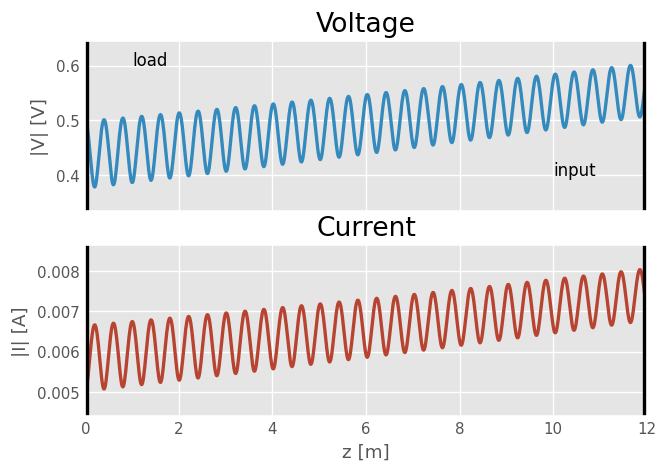

In [220]:
ig, (ax_V, ax_I) = plt.subplots(2, 1, sharex=True)
ax_V.plot(ds, abs(v2), lw=2)
ax_I.plot(ds, abs(i2), lw=2, c='C1')
ax_I.set_xlabel('z [m]')
ax_V.set_ylabel('|V| [V]')
ax_I.set_ylabel('|I| [A]')


ax_V.axvline(0, c='k', lw=5)
ax_I.axvline(0, c='k', lw=5)
ax_V.text(d-2, 0.4, 'input')
ax_V.text(1, 0.6, 'load')
ax_V.axvline(d, c='k', lw=5)
ax_I.axvline(d, c='k', lw=5)

ax_I.set_title('Current')
ax_V.set_title('Voltage')

In [221]:
print('CBL: The equivalent angle of length d is: ', np.rad2deg(d/lambd ), ' degrees')

CBL: The equivalent angle of length d is:  [855.75290382]  degrees


Text(0.5, 1.0, 'Voltage')

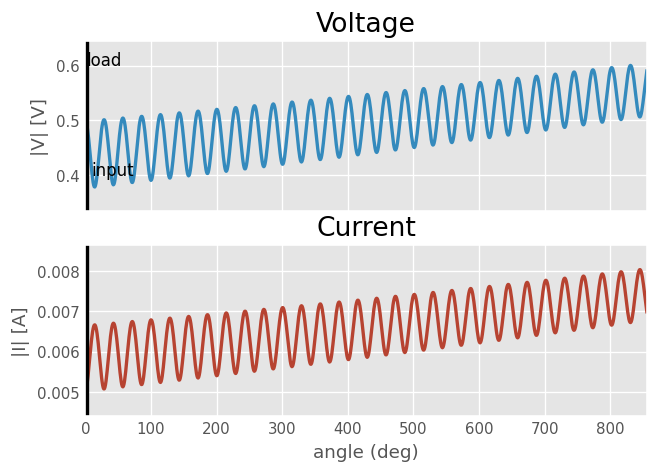

In [222]:
# redo this plot, but make it theta
ig, (ax_V, ax_I) = plt.subplots(2, 1, sharex=True)
angle = np.rad2deg(ds/lambd) 
ax_V.plot(angle, abs(v2), lw=2)
ax_I.plot(angle, abs(i2), lw=2, c='C1')
ax_I.set_xlabel('angle (deg)')
ax_V.set_ylabel('|V| [V]')
ax_I.set_ylabel('|I| [A]')


ax_V.axvline(0, c='k', lw=5)
ax_I.axvline(0, c='k', lw=5)
ax_V.text(d-2, 0.4, 'input')
ax_V.text(1, 0.6, 'load')
#ax_V.axvline(d, c='k', lw=5)
#ax_I.axvline(d, c='k', lw=5)

ax_I.set_title('Current')
ax_V.set_title('Voltage')

In [223]:
12*0.67*4

32.160000000000004